Auteurs:
- Louis PAGNIER
- Léo SRON
- Anthony BERNARD
- Junyi LI
- David FRECON

# Détection d'anomalies dans le système SWaT (Secure Water Treatment)

## Introduction

Dans ce notebook, nous allons essayer de prédire les attaques sur le système SWaT à partir des données fournies dans le dataset SWaT.A3 qui répertorie des données du 20 Juillet 2019.   
Dans ce jeu de données, 6 attaques ont été réalisées sur le système SWaT à des moments différents de la journée.

## Import des librairies

In [1]:
import pandas as pd
import random
from mlsecu.anomaly_detection_use_case import *
from mlsecu.data_exploration_utils import *
from mlsecu.data_preparation_utils import *
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import rich
import re
import matplotlib.pyplot as plt

## Définition des fonctions

Dans un premier temps, nous allons nous concentrer uniquement sur les capteurs du système et laisser de côté les pompes.

In [2]:
sensor_regex = re.compile(r'^(A|F|L|P)IT \d{3}$')
column_regex = re.compile(r'^(.*\d{3})|(.*_STATE)|(.* Status)|(.* STATE)$')

In [3]:
def normalize_df(df):
    """
    Normalize the dataset by using the min-max normalization.
    """
    df_norm = df.copy()
    for col in df_norm.columns:
        if col not in ['Timestamp', 'Attack', 'Label']:
            df_norm[col] = (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min())
    return df_norm

In [4]:
def load_df(name, only_sensors=True):
    """
    Load the dataset from the excel file.
    The parameter only_sensors allows to load only the sensors and not the pumps.
    """
    df = pd.read_excel(name, skiprows=[0, 2])
    if only_sensors:
        sensor_cols = [col for col in df.columns if sensor_regex.match(col) or col in ['Timestamp', 'Attack', 'Label']]
        df = df[sensor_cols]
    return df

In [5]:
def clean_df(df):
    """
    Clean the dataset by removing NaN values and replacing them by the corresponding missing values.
    """
    df['Attack'] = df['Attack'].fillna('benign')
    df['Label'] = df['Label'].fillna(0)
    df['Label'] = df['Label'].astype(int)
    df = df.drop(columns=['AIT 401'])
    df = df.dropna(axis=0)
    for col in df.columns:
        if col in ['Timestamp', 'Attack', 'Label']:
            continue
        # replace dictionary values
        if col[:2] == 'LS':
            df[col] = df[col].apply(lambda x: x[-2])
            df[col] = df[col].astype(int)
        # delete constant columns
        if df[col].std() == 0:
            df = df.drop(columns=[col])
    return df

In [6]:
def extract_features(df):
    """
    Extract the features from the dataset.
    """
    cols = [col for col in df.columns if column_regex.match(col)]
    df_X = df[cols]
    return df_X

def extract_labels(df, label_col='Label'):
    """
    Extract the labels from the dataset.
    """
    return df[label_col]

In [7]:
def visualize_df(df, outlier_col='Label', title='PCA', targets=[0, 1], colors=['b', 'r']):
    """
    Visualize the dataset by using PCA to reduce the dimensionality.
    """
    df_X = extract_features(df)
    df_y = extract_labels(df, outlier_col)
    
    pca = PCA(n_components=2)
    df_X_pca = pca.fit_transform(df_X)
    df_X_pca = pd.DataFrame(df_X_pca, columns=['PC1', 'PC2'])
    df_X_pca['Label'] = df_y
    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(title)
    for target, color in zip(targets, colors):
        indices_to_keep = df_X_pca['Label'] == target
        ax.scatter(df_X_pca.loc[indices_to_keep, 'PC1'], df_X_pca.loc[indices_to_keep, 'PC2'], c=color, s=50)
    ax.legend(targets)
    ax.grid()
    plt.show()
    

In [8]:
def visualize_dfs(dfs, outlier_cols=['Label'], titles=['PCA'], targets=[0, 1], colors=['b', 'r']):
    """
    Visualize multiple datasets in a row by using PCA.
    """
    fig, axs = plt.subplots(1, len(dfs), figsize=(10, 5))
    for i, df in enumerate(dfs):
        df_X = extract_features(df)
        df_y = extract_labels(df, outlier_cols[i])
        
        pca = PCA(n_components=2)
        df_X_pca = pca.fit_transform(df_X)
        df_X_pca = pd.DataFrame(df_X_pca, columns=['PC1', 'PC2'])
        df_X_pca['Label'] = df_y
        
        axs[i].set_xlabel('PC1')
        axs[i].set_ylabel('PC2')
        axs[i].set_title(titles[i])
        for target, color in zip(targets, colors):
            indices_to_keep = df_X_pca['Label'] == target
            axs[i].scatter(df_X_pca.loc[indices_to_keep, 'PC1'], df_X_pca.loc[indices_to_keep, 'PC2'], c=color, s=50)
        axs[i].legend(targets)
        axs[i].grid()
    plt.show()

In [9]:
def get_confusion_matrix(df, prediction_col, label_col):
    """
    Compute the confusion matrix from the dataset.
    """
    TP = df[(df[prediction_col] == 1) & (df[label_col] == 1)].shape[0]
    TN = df[(df[prediction_col] == 0) & (df[label_col] == 0)].shape[0]
    FP = df[(df[prediction_col] == 1) & (df[label_col] == 0)].shape[0]
    FN = df[(df[prediction_col] == 0) & (df[label_col] == 1)].shape[0]
    return TP, TN, FP, FN

In [10]:
def compute_accuracy(df, prediction_col, label_col='Label'):
    """
    Compute the accuracy from the dataset.
    """
    TP, TN, FP, FN = get_confusion_matrix(df, prediction_col, label_col)
    return (TP + TN) / (TP + TN + FP + FN)

def compute_precision(df, prediction_col, label_col='Label'):
    """
    Compute the precision from the dataset.
    """
    TP, TN, FP, FN = get_confusion_matrix(df, prediction_col, label_col)
    return TP / (TP + FP)

def compute_recall(df, prediction_col, label_col='Label'):
    """
    Compute the recall from the dataset.
    """
    TP, TN, FP, FN = get_confusion_matrix(df, prediction_col, label_col)
    return TP / (TP + FN)

In [11]:
def split_by_blocks(X, y, train_attacks=3, approximate_test_size=0.2, block_size=10*60, random_state=42):
    random.seed(random_state)
    
    n_rows = len(df)
    attacks = []
    benign = []
    attack_id = -1
    for i in range(0, n_rows):
        if y[i]:
            if i > 0 and y[i] != y[i-1]:
                attack_id += 1
                attacks.append([])
            attacks[attack_id].append(i)
        else:
            benign.append(i)
        
    random.shuffle(attacks)
    
    print(len(attacks), 'attacks detected')
        
    train_indices = []
    test_indices = []
    
    for i, attack in enumerate(attacks):
        if i < train_attacks:
            train_indices += attack
        else:
            test_indices += attack
            
    benign_blocks = []
    for i in range(0, len(benign), block_size):
        benign_blocks.append(benign[i:i+block_size])
        
    random.shuffle(benign_blocks)
    
    upper_bound = int(approximate_test_size * len(benign_blocks))
    for i, benign_block in enumerate(benign_blocks):
        if i < upper_bound:
            train_indices += benign_block
        else:
            test_indices += benign_block
            
    random.shuffle(train_indices)
    random.shuffle(test_indices)
    
    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]
    
    return X_train, X_test, y_train, y_test
    

In [12]:
def evaluate(df, prediction_col, label_col='Label', scores=None, verbose=True):
    """
    Evaluate the model
    """
    TP, TN, FP, FN = get_confusion_matrix(df, prediction_col, label_col)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    auprc = average_precision_score(df[label_col], scores) if scores is not None else None
    matthews = (TP * TN - FP * FN) / (((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5)
    if verbose:
        print('Accuracy: {:.2f}'.format(accuracy))
        print('Precision: {:.2f}'.format(precision))
        print('Recall: {:.2f}'.format(recall))
        if auprc is not None:
            print('AUPRC: {:.2f}'.format(auprc))
        print('Matthews: {:.2f}'.format(matthews))
    return accuracy, precision, recall, auprc, matthews

In [13]:
def predict_if(df, rate=0.17):
    # Remove extra columns (These columns must not be used for the detection of outliers)
    df_if = extract_features(df).copy()
    _if = IsolationForest(contamination=rate, random_state=42)
    _if.fit(df_if)
    if_scores = _if.score_samples(df_if)
    df_if['if_outliers'] = _if.predict(df_if)
    df_if['if_outliers'] = df_if['if_outliers'].map({1: 0, -1: 1})
    # restore extra columns
    df_if['Timestamp'] = df['Timestamp']
    df_if['Attack'] = df['Attack']
    df_if['Label'] = df['Label']
    
    return df_if, if_scores

In [14]:
def predict_lof(df, rate):
    # Remove extra columns (These columns must not be used for the detection of outliers)
    df_lof = extract_features(df).copy()
    _lof = LocalOutlierFactor(n_neighbors=20, contamination=rate)
    df_lof['lof_outliers'] = _lof.fit_predict(df_lof)
    df_lof['lof_outliers'] = df_lof['lof_outliers'].map({1: 0, -1: 1})
    # restore extra columns
    df_lof['Timestamp'] = df['Timestamp']
    df_lof['Attack'] = df['Attack']
    df_lof['Label'] = df['Label']
    
    return df_lof, _lof.negative_outlier_factor_

In [15]:
def calculate_rms(df):
    """
    Calculate the Root Mean Square (RMS) for each column in the DataFrame, excluding 'Timestamp', 'Attack', and 'Label'.
    """
    rms = df.drop(columns=['Timestamp', 'Attack', 'Label']).apply(lambda x: np.sqrt(np.mean(np.square(x))))
    return rms

In [16]:
def diff_df(df):
    """
    Replace the values of the dataframe by the difference with the previous value.
    """
    df_diff = df.copy()
    for col in df_diff.columns:
        if col not in ['Timestamp', 'Attack', 'Label']:
            df_diff[col] = df_diff[col].diff()
    df_diff = df_diff.dropna()
    return df_diff

## Chargement des données

Avant de commencer, nous allons charger les données du dataset SWaT.A3.

In [17]:
df = load_df('data/SWaT.A3_dataset_Jul 19_labelled.xlsx', only_sensors=False)
df = clean_df(df)
df = normalize_df(df)
df.head()

,Timestamp,Attack,Label,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,AIT 201,AIT 202,...,FIT 502,FIT 503,FIT 504,MV 501,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,P601 Status
0,2019-07-20T04:30:00Z,benign,0,0.0,0.714823,0.5,1.0,1.0,0.869776,0.726909,...,0.600898,0.217869,0.198020,1.0,0.155526,0.002699,0.140332,0.002333,1.0,0.0
1,2019-07-20T04:30:01Z,benign,0,0.0,0.713530,0.5,1.0,1.0,0.869776,0.726909,...,0.610127,0.217869,0.192244,1.0,0.155526,0.002699,0.140332,0.002333,1.0,0.0
2,2019-07-20T04:30:02.004013Z,benign,0,0.0,0.712590,0.5,1.0,1.0,0.869776,0.726909,...,0.613869,0.217869,0.192244,1.0,0.155526,0.002699,0.140332,0.002333,1.0,0.0
3,2019-07-20T04:30:03.004013Z,benign,0,0.0,0.711297,0.5,1.0,1.0,0.869776,0.721581,...,0.596408,0.217869,0.189769,1.0,0.155526,0.002699,0.140332,0.002333,1.0,0.0
4,2019-07-20T04:30:04Z,benign,0,0.0,0.708358,0.5,1.0,1.0,0.869776,0.721581,...,0.587428,0.217869,0.205446,1.0,0.155526,0.002699,0.140332,0.002333,1.0,0.0


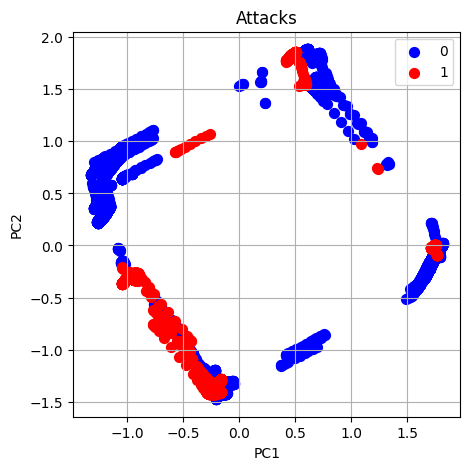

In [18]:
visualize_df(df, title='Attacks')

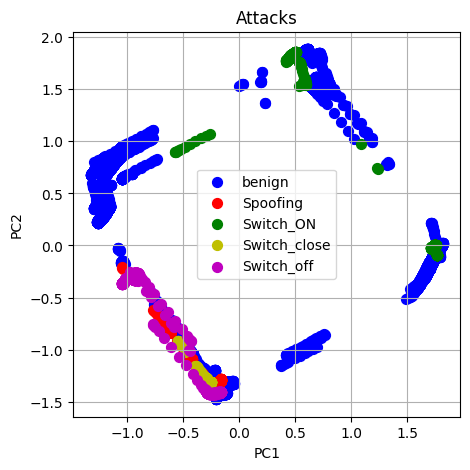

In [19]:
visualize_df(df, title='Attacks', outlier_col='Attack', targets=['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'], colors=['b', 'r', 'g', 'y', 'm'])

In [20]:
print("proportion d'attaques dans le dataset:", len(df.loc[df.Label == 1]) / len(df))

proportion d'attaques dans le dataset: 0.17024539877300612


## Détection d'anomalies

Nous allons désormais utiliser les fonctions définies précédemment pour détecter les anomalies dans le dataset.

### Isolation Forest

La première méthode que nous allons utiliser pour déterminer les outliers est Isolation Forest. Cette méthode est basée sur la construction d'arbres de décision aléatoires. Elle permet de déterminer les outliers en fonction du nombre de splits nécessaires pour isoler un point. Plus le nombre de splits est faible, plus le point est considéré comme un outlier.

In [21]:
# Remove extra columns (These columns must not be used for the detection of outliers)
df_if, if_scores = predict_if(df, rate=0.15)

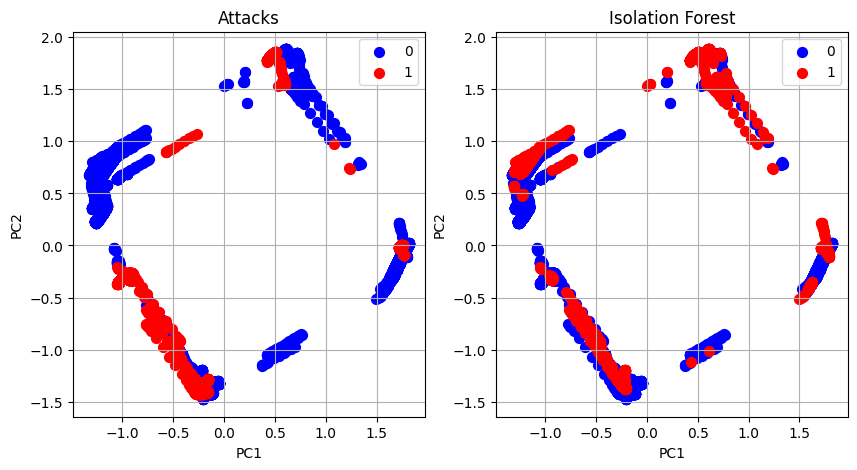

In [22]:
visualize_dfs([df, df_if], ['Label', 'if_outliers'], titles=['Attacks', 'Isolation Forest'])

In [23]:
_ = evaluate(df_if, 'if_outliers', scores=if_scores)

Accuracy: 0.79
Precision: 0.37
Recall: 0.33
AUPRC: 0.11
Matthews: 0.23


On peut voir que la méthode Isolation Forest permet de détecter les anomalies avec une accuracy de 0.82, une precision de 0.32 et un recall de 0.06.  
Ces résultats sont assez mauvais. Dans notre cas, la métrique la plus importante est le recall car elle indique le nombre d'attaques détectées par rapport au nombre d'attaques réelles.

### Local Outlier Factor
La seconde méthode que nous utilisons est également une méthode d'apprentissage non suprvisée.

In [24]:
df_lof, lof_scores = predict_lof(df, rate=0.15)

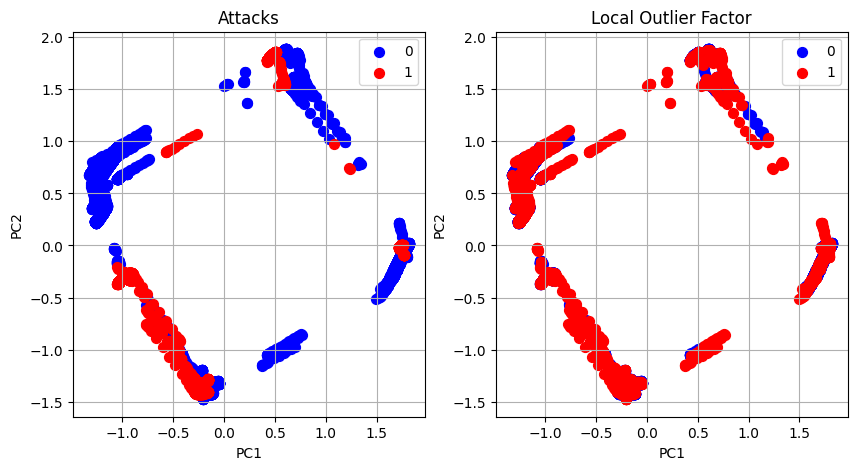

In [25]:
visualize_dfs([df, df_lof], ['Label', 'lof_outliers'], titles=['Attacks', 'Local Outlier Factor'])

In [26]:
_ = evaluate(df_lof, 'lof_outliers', scores=lof_scores)

Accuracy: 0.75
Precision: 0.23
Recall: 0.20
AUPRC: 0.16
Matthews: 0.07


# Etudes des données

In [27]:
print("La taille du dataset est", len(df))

attack_labels = df['Attack'].unique()

# Print the unique attack labels
print("Les types d'attaque sont", attack_labels)
print ("Le nombre d'attaques 'non-bénigne' est", len(df.loc[df.Label == 1]))

La taille du dataset est 14996
Les types d'attaque sont ['benign' 'Spoofing' 'Switch_ON' 'Switch_close' 'Switch_off']
Le nombre d'attaques 'non-bénigne' est 2553


5 types d'attaque:

-benign: Attaque bénigne, labelisée 0;

-Spoofing: Attque impliquant une usurpation d'identité, labélisée 1;

-Switch_ON:

-Switch_close:

-Switch_off:

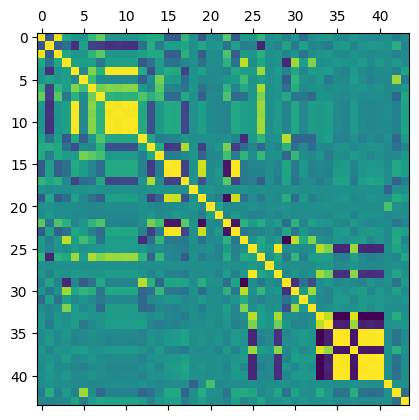

In [28]:
df_feat = extract_features(df).copy()
corr_matrix = df_feat.corr()

# Print the correlation matrix
corr_matrix.style.background_gradient(cmap='coolwarm')
plt.matshow(corr_matrix)

Correlation élevée entre features FIT 501	FIT 502	FIT 503	FIT 504	PIT 501	PIT 502	PIT 503

In [29]:
spoof_attacks = df[df['Attack'] == 'Spoofing']
avg_sensor_readings_before_spoof = spoof_attacks.iloc[:24, 1:].mean(numeric_only=True)
avg_sensor_readings_after_spoof = spoof_attacks.iloc[24:, 1:].mean(numeric_only=True)
change_in_avg_sensor_readings = avg_sensor_readings_after_spoof - avg_sensor_readings_before_spoof
print(change_in_avg_sensor_readings)

Label          0.000000
FIT 101        0.000000
LIT 101       -0.001740
MV 101         0.000000
P1_STATE       0.000000
P101 Status    0.000000
AIT 201       -0.001286
AIT 202       -0.108577
AIT 203       -0.033475
FIT 201       -0.000042
MV201          0.000000
P203 Status    0.000000
P205 Status    0.000000
AIT 301       -0.005744
AIT 302       -0.335001
AIT 303        0.051427
DPIT 301       0.616671
FIT 301        0.356878
LIT 301        0.024642
MV 301         0.000000
MV 302         0.462099
MV 303         0.000000
MV 304        -0.354592
P3_STATE       0.031792
P301 Status    0.125000
AIT 402       -0.006175
FIT 401        0.643607
LIT 401        0.218727
P401 Status   -0.002915
UV401          0.763848
AIT 501        0.005288
AIT 502        0.018888
AIT 503       -0.139441
AIT 504        0.001845
FIT 501       -0.000230
FIT 502        0.007311
FIT 503       -0.000929
FIT 504       -0.001606
MV 501         0.000000
PIT 501        0.000680
PIT 502       -0.000079
PIT 503       -0

Le sensor LIT 401 réagit aux attaques de spoofing.

In [30]:
on_attacks = df[df['Attack'] == 'Switch_ON']
avg_sensor_readings_before_on = on_attacks.iloc[:24, 1:].mean(numeric_only=True)
avg_sensor_readings_after_on = on_attacks.iloc[24:, 1:].mean(numeric_only=True)
change_in_avg_sensor_readings = avg_sensor_readings_after_on - avg_sensor_readings_before_on
print(change_in_avg_sensor_readings)

Label          0.000000
FIT 101        0.496098
LIT 101       -0.126791
MV 101         0.217988
P1_STATE       0.000000
P101 Status    0.000000
AIT 201       -0.631972
AIT 202       -0.194200
AIT 203       -0.001115
FIT 201       -0.013920
MV201          0.000000
P203 Status   -0.018293
P205 Status   -0.018293
AIT 301        0.007977
AIT 302        0.240888
AIT 303       -0.045009
DPIT 301      -0.640465
FIT 301       -0.632642
LIT 301        0.452214
MV 301         0.000000
MV 302        -0.344512
MV 303         0.000000
MV 304         0.000000
P3_STATE       0.654953
P301 Status   -0.690549
AIT 402       -0.013356
FIT 401        0.003883
LIT 401       -0.166852
P401 Status    0.000000
UV401          0.000000
AIT 501       -0.001049
AIT 502       -0.013213
AIT 503       -0.091328
AIT 504        0.004113
FIT 501        0.001735
FIT 502        0.003527
FIT 503       -0.003053
FIT 504       -0.000491
MV 501         0.000000
PIT 501       -0.002491
PIT 502        0.000151
PIT 503       -0

Le sensor LIT 301 réagit aux attaques de type switch_on.

In [31]:
off_attacks = df[df['Attack'] == 'Switch_off']
avg_sensor_readings_before_off = off_attacks.iloc[:24, 1:].mean(numeric_only=True)
avg_sensor_readings_after_off = off_attacks.iloc[24:, 1:].mean(numeric_only=True)
change_in_avg_sensor_readings = avg_sensor_readings_after_off - avg_sensor_readings_before_off
print(change_in_avg_sensor_readings)

Label          0.000000
FIT 101        0.000000
LIT 101       -0.001081
MV 101         0.000000
P1_STATE       0.000000
P101 Status    0.000000
AIT 201        0.000975
AIT 202       -0.192117
AIT 203       -0.063567
FIT 201        0.000028
MV201          0.000000
P203 Status    0.000000
P205 Status    0.000000
AIT 301        0.018448
AIT 302        0.197854
AIT 303        0.019823
DPIT 301       0.034671
FIT 301        0.003380
LIT 301       -0.080635
MV 301        -0.004484
MV 302        -0.033632
MV 303         0.020553
MV 304         0.013827
P3_STATE       0.004608
P301 Status    0.325859
AIT 402        0.002769
FIT 401       -0.000864
LIT 401       -0.286237
P401 Status    0.000000
UV401          0.000000
AIT 501        0.008790
AIT 502        0.002415
AIT 503       -0.013576
AIT 504        0.013135
FIT 501        0.001780
FIT 502       -0.007835
FIT 503       -0.000899
FIT 504        0.004002
MV 501         0.000000
PIT 501       -0.003643
PIT 502       -0.000306
PIT 503       -0

Le sensor LIT 401 réagit aux attaques de type switch_off.

In [32]:
calculate_rms(df)

FIT 101        0.407550
LIT 101        0.799414
MV 101         0.609179
P1_STATE       0.248227
P101 Status    0.611691
AIT 201        0.796202
AIT 202        0.658634
AIT 203        0.691064
FIT 201        0.605817
MV201          0.728211
P203 Status    0.608303
P205 Status    0.608303
AIT 301        0.705010
AIT 302        0.670886
AIT 303        0.436052
DPIT 301       0.657200
FIT 301        0.640569
LIT 301        0.614493
MV 301         0.499900
MV 302         0.798396
MV 303         0.502942
MV 304         0.513066
P3_STATE       0.677540
P301 Status    0.691034
AIT 402        0.209605
FIT 401        0.938848
LIT 401        0.583376
P401 Status    0.999933
UV401          0.991898
AIT 501        0.823977
AIT 502        0.137982
AIT 503        0.552327
AIT 504        0.104216
FIT 501        0.924435
FIT 502        0.665148
FIT 503        0.174720
FIT 504        0.190824
MV 501         0.995924
PIT 501        0.102838
PIT 502        0.096454
PIT 503        0.108192
FIT 601        0

In [33]:
df_diff = diff_df(df)
df_diff

,Timestamp,Attack,Label,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,AIT 201,AIT 202,...,FIT 502,FIT 503,FIT 504,MV 501,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,P601 Status
1,2019-07-20T04:30:01Z,benign,0,0.000000,-0.001293,0.0,0.0,0.0,0.0,0.000000,...,0.009229,0.000000,-0.005776,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,2019-07-20T04:30:02.004013Z,benign,0,0.000000,-0.000940,0.0,0.0,0.0,0.0,0.000000,...,0.003742,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,2019-07-20T04:30:03.004013Z,benign,0,0.000000,-0.001293,0.0,0.0,0.0,0.0,-0.005328,...,-0.017461,0.000000,-0.002475,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,2019-07-20T04:30:04Z,benign,0,0.000000,-0.002939,0.0,0.0,0.0,0.0,0.000000,...,-0.008980,0.000000,0.015677,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
5,2019-07-20T04:30:05Z,benign,0,0.000000,-0.001646,0.0,0.0,0.0,0.0,0.000000,...,-0.013969,0.000000,0.008251,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14991,2019-07-20T08:39:55.001007Z,benign,0,0.020729,0.000000,0.0,0.0,0.0,0.0,-0.001775,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
14992,2019-07-20T08:39:56.0050048Z,benign,0,0.012146,0.000705,0.0,0.0,0.0,0.0,-0.003553,...,0.014467,-0.009622,0.000000,0.0,0.000526,0.0,0.0,0.0,0.0,0.0
14993,2019-07-20T08:39:57.0050048Z,benign,0,0.011274,0.002704,0.0,0.0,0.0,0.0,0.000000,...,-0.009479,0.000000,0.000000,0.0,0.000789,0.0,0.0,0.0,0.0,0.0
14994,2019-07-20T08:39:58.0050048Z,benign,0,0.004582,0.000470,0.0,0.0,0.0,0.0,-0.000888,...,-0.023447,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


## LSTM

In [34]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

2023-11-06 11:12:18.824202: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 11:12:18.851930: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 11:12:18.852384: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 11:12:19.683772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [35]:
df_lstm = df.copy()
df_lstm = df_lstm.drop(columns=['Timestamp', 'Attack', 'Label'])

In [36]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm = scaler.fit_transform(df_lstm)

In [37]:
train_size = int(len(df_lstm) * 0.8)
test_size = len(df_lstm) - train_size
train, test = df_lstm[0:train_size,:], df_lstm[train_size:len(df_lstm),:]
print(len(train), len(test))

11996 3000


In [38]:
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [39]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2023-11-06 11:12:20.382187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 11:12:20.382699: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                18800     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 18851 (73.64 KB)
Trainable params: 18851 (73.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
167/167 - 2s - loss: 0.5308 - accuracy: 0.7827 - val_loss: 0.1567 - val_accuracy: 0.9943 - 2s/epoch - 15ms/step
Epoch 2/50
167/167 - 0s - loss: 0.4187 - accuracy: 0.7833 - val_loss: 0.0927 - val_accuracy: 0.9943 - 303ms/epoch - 2ms/step
Epoch 3/50
167/167 - 0s - loss: 0.3583 - accuracy: 0.7572 - val_loss: 0.0542 - val_accuracy: 0.9943 - 427ms/epoch - 3ms/step
Epoch 4/50
167/167 - 0s - loss: 0.3206 - accuracy: 0.7516 - val_loss: 0.0399 - val_accuracy: 0.9943 - 313ms/epoch - 2ms/step
Epoch 5/50
167/167 - 0s - loss: 0.2878 - accuracy: 0.7517 - val_loss: 0.0340 - val_accuracy: 0.9943 - 341ms/epoch - 2ms/step
Epoch 6/50
167/167 - 0s - loss: 0.2546 - accuracy: 0.7541 - val_loss: 0.0314 - val_accuracy: 0.9943 - 352ms/epoch - 2ms/step
Epoch 7/50
167/167 - 0s - loss: 0.2214 - accuracy: 0.7636 - val_loss: 0.0306 - val_accuracy: 0.9943 - 307ms/epoch - 2ms/step
Epoch 8/50
167/167 - 0s - loss: 0.1909 - accuracy: 0.7692 - val_loss: 0.0309 - val_accuracy: 0.9943 - 368ms/epoch - 2ms/step
Ep

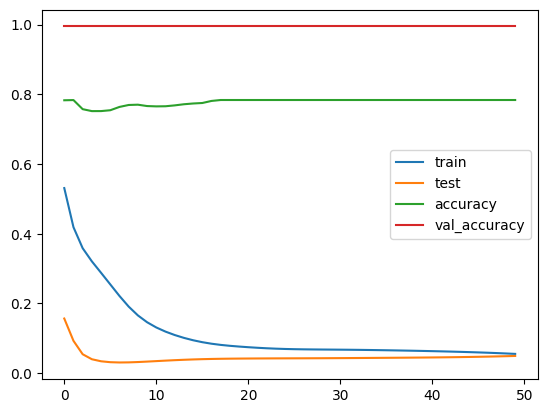

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [43]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = inv_y[:,0]

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

94/94 [==============================] - 0s 975us/step
Test RMSE: 0.055


### Autres algorithmes

Comme le dataset est labellisé, nous allons utiliser des algorithmes de classification pour avoir une meilleure prédiction.

In [44]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Extract features and labels
df_boost = df.copy()
labels = extract_labels(df_boost)

# boost_train & boost_test are the datasets used for training and testing the model
# in opposite to X_train & X_test, they contain extra columns (Attack, Label, Timestamp)
boost_train, boost_test, y_train, y_test = split_by_blocks(df_boost, labels)
X_train = extract_features(boost_train)
X_test = extract_features(boost_test)

6 attacks detected


In [45]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.76%


In [46]:
boost_test['xgb_predictions'] = y_pred
evaluate(boost_test, 'xgb_predictions')

Accuracy: 0.85
Precision: 0.46
Recall: 0.60
Matthews: 0.44


/tmp/ipykernel_25810/2004268875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boost_test['xgb_predictions'] = y_pred


(0.8476190476190476,
 0.46095238095238095,
 0.6004962779156328,
 None,
 0.43814120224369857)

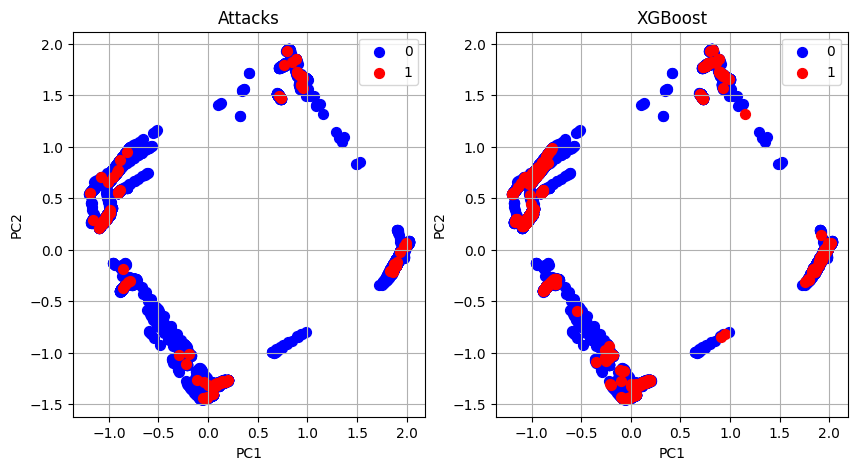

In [47]:
visualize_dfs([boost_test, boost_test], ['Label', 'xgb_predictions'], titles=['Attacks', 'XGBoost'])